In [17]:
#|default_exp accel

# Denoising Diffusion Probabilistic Models with miniai

## Imports

In [18]:
#|export
import pickle,gzip,math,os,time,shutil,torch,random,logging
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from functools import partial
from types import SimpleNamespace

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *

In [19]:
mpl.rcParams['image.cmap'] = 'gray_r'
logging.disable(logging.WARNING)

## Load the dataset

In [20]:
config = SimpleNamespace(    
    epochs = 15,
    model_name="ddpm_mmnist_miniai",
    noise_steps=1000,
    seed = 42,
    batch_size = 512,
    img_size = 40,
    device = "cuda",
    use_wandb = True,
    num_workers=8,
    num_frames=3,
    lr = 1e-3)

In [21]:
ds = torch.load("mmnist_01_40x40.pt") - 0.5
# ds = ds[0:3000]

In [22]:
ds.device, ds.shape

(device(type='cpu'), torch.Size([128000, 4, 1, 40, 40]))

In [23]:
split_val = int(0.9*len(ds))
train_ds = ds[:split_val].squeeze()
valid_ds = ds[split_val:].squeeze()

train_dl = DataLoader(train_ds, config.batch_size, num_workers=config.num_workers, pin_memory=True)
valid_dl = DataLoader(valid_ds, config.batch_size, num_workers=config.num_workers)

In [24]:
dls = DataLoaders(train_dl, valid_dl)

In [25]:
dt = dls.train
xb = next(iter(dt))
xb.shape

torch.Size([512, 4, 40, 40])

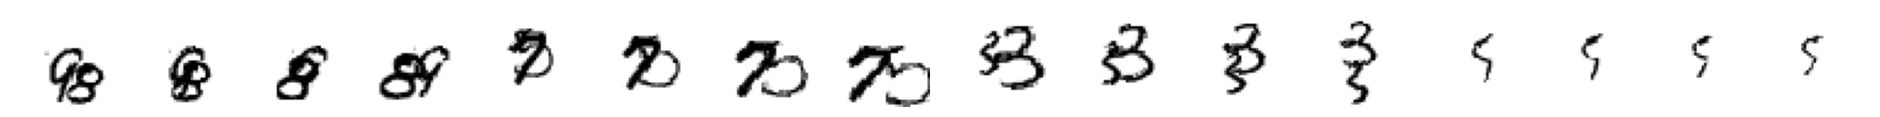

In [26]:
show_images(xb[:4].reshape(-1, 1, config.img_size, config.img_size), imsize=1.5)

In [27]:
betamin,betamax,n_steps = 0.0001,0.02,config.noise_steps
beta = torch.linspace(betamin, betamax, n_steps)
alpha = 1.-beta
alphabar = alpha.cumprod(dim=0)
sigma = beta.sqrt()

In [14]:
def noisify(x0, ᾱ):
    "Noise only the last frame"
    past_frames = x0[:,:-1]
    x0 = x0[:,-1:]
    device = x0.device
    n = len(x0)
    t = torch.randint(0, n_steps, (n,), dtype=torch.long)
    ε = torch.randn(x0.shape, device=device)
    ᾱ_t = ᾱ[t].reshape(-1, 1, 1, 1).to(device)
    xt = ᾱ_t.sqrt()*x0 + (1-ᾱ_t).sqrt()*ε
    return torch.cat([past_frames, xt], dim=1), t.to(device), ε

In [15]:
xt, t, ε = noisify(xb[:4],alphabar)
t

tensor([197, 302, 785, 452])

In [16]:
xt.shape

torch.Size([4, 4, 40, 40])

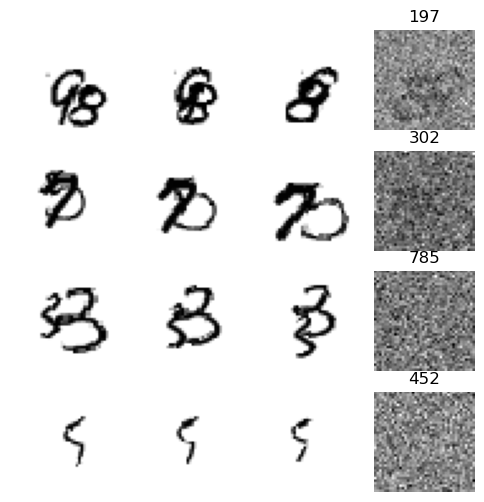

In [17]:
titles = fc.map_ex(t, '{}')
titles = fc.concat(zip([[None,None,None]]*len(titles), titles)) 
show_images(xt.reshape(-1, 1, config.img_size, config.img_size), imsize=1.5, titles=titles)

## Training

In [102]:
from diffusers import UNet2DModel

In [103]:
def init_ddpm(model):
    for o in model.down_blocks:
        for p in o.resnets:
            p.conv2.weight.data.zero_()
            for p in fc.L(o.downsamplers): init.orthogonal_(p.conv.weight)

    for o in model.up_blocks:
        for p in o.resnets: p.conv2.weight.data.zero_()

    model.conv_out.weight.data.zero_()

In [104]:
def collate_ddpm(b): return noisify(default_collate(b), alphabar)

In [105]:
def dl_ddpm(ds, shuffle=False): return DataLoader(ds, batch_size=config.batch_size, collate_fn=collate_ddpm, shuffle=shuffle, num_workers=config.num_workers)

In [106]:
dls = DataLoaders(dl_ddpm(train_ds, shuffle=True), dl_ddpm(valid_ds))

In [107]:
from fastprogress import progress_bar

In [108]:
@torch.no_grad()
def sample(model, xt):
    ps = next(model.parameters())
    past_frames = xt[:,:-1]
    x_t = torch.randn_like(xt[:,-1:], dtype=xt.dtype)
    preds = []
    for t in progress_bar(reversed(range(n_steps)), total=n_steps, leave=False):
        t_batch = torch.full((x_t.shape[0],), t, device=ps.device, dtype=torch.long)
        z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(ps)
        ᾱ_t1 = alphabar[t-1]  if t > 0 else torch.tensor(1)
        b̄_t = 1-alphabar[t]
        b̄_t1 = 1-ᾱ_t1
        noise = model(torch.cat([past_frames, x_t], dim=1), t_batch).sample
        x_0_hat = ((x_t - b̄_t.sqrt() * noise)/alphabar[t].sqrt())
        x_t = x_0_hat * ᾱ_t1.sqrt()*(1-alpha[t])/b̄_t + x_t * alpha[t].sqrt()*b̄_t1/b̄_t + sigma[t]*z
        preds.append(x_t.float().cpu())
    return preds

## Accelerate

`pip install accelerate` before running this section.

In [109]:
#|export
from accelerate import Accelerator

In [110]:
#|export
class AccelerateCB(TrainCB):
    order = DeviceCB.order+10
    def __init__(self, n_inp=1, mixed_precision="fp16"):
        super().__init__(n_inp=n_inp)
        self.acc = Accelerator(mixed_precision=mixed_precision)
        
    def before_fit(self, learn):
        learn.model,learn.opt,learn.dls.train,learn.dls.valid = self.acc.prepare(
            learn.model, learn.opt, learn.dls.train, learn.dls.valid)
    
    def after_fit(self, learn):
        learn.model = self.acc.unwrap_model(learn.model)
    
    def backward(self, learn): self.acc.backward(learn.loss)

In [111]:
import wandb
class WandbCB(Callback):
    "Hacky W&B callback"
    order = MetricsCB.order+1
    def __init__(self, model_name=None): self.model_name = model_name
    def before_fit(self, learn):
        if wandb.run is None:
            raise Exception("You have to run fit inside a wandb run")
        if hasattr(learn, 'metrics'): 
            self._log_copy = learn.metrics._log
            learn.metrics._log = self._log
        self.losses = []

    def _log(self, d):
        self._log_copy(d)
        wandb.log(d)
    
    def after_batch(self, learn):
        if learn.training:
            wandb.log({"train_loss":learn.loss.item()})
                       # "lr":learn.schedo.get_last_lr()[0]})
    def after_fit(self, learn):
        if self.model_name is not None:
            model_name = f"{wandb.run.id}_{self.model_name}"
            at = wandb.Artifact(model_name, type="model")
            torch.save(learn.model.state_dict(), f"models/{self.model_name}.pth")
            at.add_file(f"models/{self.model_name}.pth")
            wandb.log_artifact(at)

In [112]:
def to_wandb_image(img):
    return wandb.Image(torch.cat(img.split(1), dim=-1).cpu().numpy())

def log_images(model, xt):
    samples = sample(model, xt)
    frames = torch.cat([xt[:, :-1,...].to(samples[-1].device), samples[-1]], dim=1)
    wandb.log({"sampled_images": [to_wandb_image(img) for img in frames]})

In [113]:
class LogPreds(Callback):
    "Log samples to W&B"
    order = WandbCB.order+1
    def __init__(self, n_preds=10): self.n_preds=n_preds
    
    def before_fit(self, learn):
        dt = learn.dls.valid
        xt, t, ε = next(iter(dt))
        self.xt = xt[:self.n_preds]
    
    def after_epoch(self, learn):
        if not learn.training:
            log_images(learn.model, self.xt)

In [114]:
class DDPMCB2(Callback):
    def after_predict(self, learn): learn.preds = learn.preds.sample

In [115]:
tmax = config.epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=config.lr, total_steps=tmax)
opt_func = partial(optim.Adam, eps=1e-5)

In [116]:
model = UNet2DModel(in_channels=4, out_channels=1, block_out_channels=(16, 32, 64, 128), norm_num_groups=8)
init_ddpm(model)
cbs = [DDPMCB2(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched), AccelerateCB(n_inp=2)]
learn = Learner(model, dls, nn.MSELoss(reduction="sum"), lr=config.lr, cbs=cbs, opt_func=opt_func)

In [117]:
{cb.__class__.__name__:cb.order for cb in learn.cbs}

{'DDPMCB2': 0,
 'ProgressCB': 1,
 'MetricsCB': 0,
 'BatchSchedCB': 0,
 'AccelerateCB': 10}

loss,epoch,train
147835.281,0,train
44885.996,0,eval
23961.684,1,train
18409.346,1,eval
16554.537,2,train
17707.328,2,eval
14658.118,3,train
13730.545,3,eval
13215.435,4,train
12733.077,4,eval


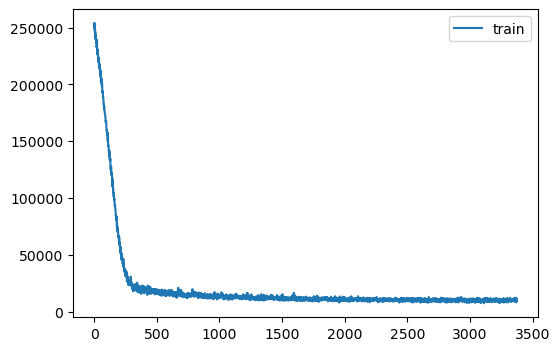

epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
train_loss,█▆▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,14
loss,10281.044
train,eval
train_loss,11134.34082


In [119]:
with wandb.init(project="miniai_ddpm_", config=config):
    learn.fit(config.epochs, cbs=[WandbCB("test_model"), LogPreds()])

For sampling, we have to replace the last frame by pure noise

In [ ]:
# @torch.no_grad()
# def sample2(model, xt):
#     ps = next(model.parameters())
#     past_frames = xt[:,:-1].to(ps)
#     x_t = torch.randn_like(xt[:,-1:]).to(ps)
#     sample_at = {t for t in range(n_steps) if (t+101)%((t+101)//100)==0}
#     preds = []
#     for t in progress_bar(reversed(range(n_steps)), total=n_steps):
#         t_batch = torch.full((x_t.shape[0],), t, device=ps.device, dtype=torch.long)
#         z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(ps)
#         ᾱ_t1 = alphabar[t-1]  if t > 0 else torch.tensor(1)
#         b̄_t = 1-alphabar[t]
#         b̄_t1 = 1-ᾱ_t1
#         if t in sample_at: noise = model(torch.cat([past_frames, x_t], dim=1), t_batch).sample
#         x_0_hat = ((x_t - b̄_t.sqrt() * noise)/alphabar[t].sqrt())
#         x_t = x_0_hat * ᾱ_t1.sqrt()*(1-alpha[t])/b̄_t + x_t * alpha[t].sqrt()*b̄_t1/b̄_t + sigma[t]*z
#         if t in sample_at: preds.append(x_t.float().cpu())
#     return preds

## Generate Longer sequences...

The idea is use the same model in an autorgressive way so we can generate arbitrary long sequences.

Let's load the trained model

In [1]:
import torch
from diffusers import UNet2DModel

from fastprogress import progress_bar

In [28]:
@torch.no_grad()
def sample(model, xt):
    ps = next(model.parameters())
    xt = xt.to(ps.device)
    past_frames = xt[:,:-1]
    x_t = torch.randn_like(xt[:,-1:], dtype=xt.dtype)
    preds = []
    for t in progress_bar(reversed(range(n_steps)), total=n_steps, leave=False):
        t_batch = torch.full((x_t.shape[0],), t, device=ps.device, dtype=torch.long)
        z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(ps)
        ᾱ_t1 = alphabar[t-1]  if t > 0 else torch.tensor(1)
        b̄_t = 1-alphabar[t]
        b̄_t1 = 1-ᾱ_t1
        noise = model(torch.cat([past_frames, x_t], dim=1), t_batch).sample
        x_0_hat = ((x_t - b̄_t.sqrt() * noise)/alphabar[t].sqrt())
        x_t = x_0_hat * ᾱ_t1.sqrt()*(1-alpha[t])/b̄_t + x_t * alpha[t].sqrt()*b̄_t1/b̄_t + sigma[t]*z
    return x_t.float()


In [29]:
ds = torch.load("mmnist_01_40x40.pt") - 0.5
# ds = ds[0:3000]

In [30]:
model = UNet2DModel(in_channels=4, out_channels=1, block_out_channels=(16, 32, 64, 128), norm_num_groups=8)

In [31]:
model.load_state_dict(torch.load("models/test_model.pth"))
model.eval();

In [32]:
num_samples = 10
num_preds = 5

In [33]:
xt = ds[:num_samples].squeeze().cuda()
xt.shape

torch.Size([10, 4, 40, 40])

In [34]:
preds = []

for i in progress_bar(range(num_preds), total=num_preds):
    pred = sample(model.to(config.device), xt.cuda())
    preds.append(pred)
    xt = torch.cat([xt[:, 1:], pred], dim=1)

In [35]:
preds[0].shape

torch.Size([10, 1, 40, 40])

In [36]:
past = ds[:num_samples].squeeze()

future = torch.cat(preds, dim=1).cpu()
past.shape, past.device, future.shape, future.device

(torch.Size([10, 4, 40, 40]),
 device(type='cpu'),
 torch.Size([10, 5, 40, 40]),
 device(type='cpu'))

In [42]:
frames = torch.cat([past, future], dim=1).reshape(-1, 1, config.img_size, config.img_size)

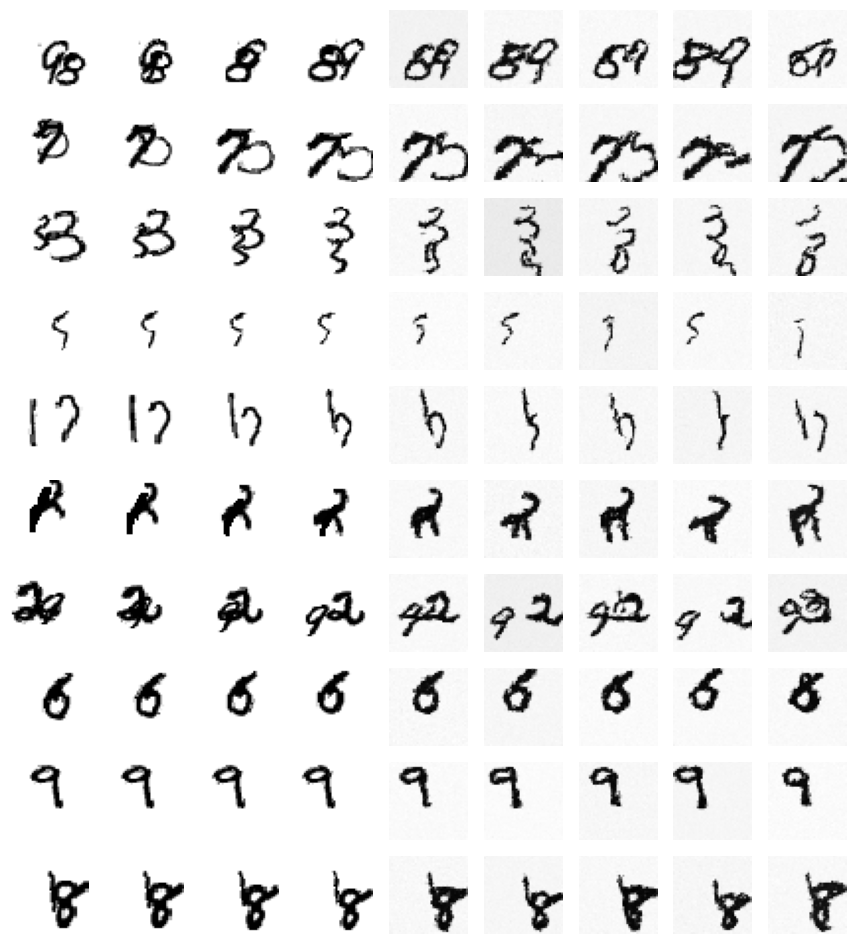

In [48]:
show_images(frames, nrows=10, imsize=1.2)